# Metodología para clasificación de sellers

In [1]:
import requests # para consultas a la API de Mercado Libre
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # para visualización de datos
import seaborn as sns # para visualización de datos
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

## 1. Extracción de datos y creación de datamart

### Extracción de datos
Buscamos obtener la mayor cantidad de items para una gran población de sellers para poder hacer el análisis por lo que primeros e hará una extracción de las categorías para hacer un muestreo de items por categoría y tener una muestra amplia de sellers.  
Una vez obtenida la lsita de sellers se hace una extracicón de la mayor cantidad posible de items de cada seller para cada categoría

In [2]:
# request de categorías deisponibles para México usando el código MLM
codigo = "MLM"
cats = requests.get('https://api.mercadolibre.com/sites/{}/categories'.format(codigo)) 
cats.json()

[{'id': 'MLM1747', 'name': 'Accesorios para Vehículos'},
 {'id': 'MLM189530', 'name': 'Agro'},
 {'id': 'MLM1403', 'name': 'Alimentos y Bebidas'},
 {'id': 'MLM1071', 'name': 'Animales y Mascotas'},
 {'id': 'MLM1367', 'name': 'Antigüedades y Colecciones'},
 {'id': 'MLM1368', 'name': 'Arte, Papelería y Mercería'},
 {'id': 'MLM1743', 'name': 'Autos, Motos y Otros'},
 {'id': 'MLM1384', 'name': 'Bebés'},
 {'id': 'MLM1246', 'name': 'Belleza y Cuidado Personal'},
 {'id': 'MLM1039', 'name': 'Cámaras y Accesorios'},
 {'id': 'MLM1051', 'name': 'Celulares y Telefonía'},
 {'id': 'MLM1648', 'name': 'Computación'},
 {'id': 'MLM1144', 'name': 'Consolas y Videojuegos'},
 {'id': 'MLM1500', 'name': 'Construcción'},
 {'id': 'MLM1276', 'name': 'Deportes y Fitness'},
 {'id': 'MLM1575', 'name': 'Electrodomésticos'},
 {'id': 'MLM1000', 'name': 'Electrónica, Audio y Video'},
 {'id': 'MLM186863', 'name': 'Herramientas'},
 {'id': 'MLM1574', 'name': 'Hogar, Muebles y Jardín'},
 {'id': 'MLM1499', 'name': 'Industri

In [22]:
# Muestreo de items (100) por categoría para obtener distintos sellers
n_items = 100
categories = [aux["id"] for aux in cats.json()]
items = [requests.get("https://api.mercadolibre.com/sites/MLM/search?category={}&offset={}".format(cat,off)).json() for off in range(0,n_items,50) for cat in categories]

In [23]:
# lista con sellers únicos del muestreo anterior
sellers = list(set([items[i]["results"][j]["seller"]["id"]  for i in range(len(items)) if "results" in items[i] for j in range(len(items[i]["results"])) if "results" in items[i]]))
#n_sellers = 50 # descomentar para obtener el análisis sobre un universo más pequeño (50 sellers)
#sellers = sellers[0:n_sellers] # descomentar para obtener el análisis sobre un universo más pequeño (50 sellers)

In [24]:
def getItems(seller, category):
    '''
    Función para obtener los items del seller iterativamente hasta que haya encontrado todos los items disponibles o haya alcanzado el máximo offset para una sola categoría
    INPUT:
    - seller: [int] id_seller
    - category: [str] con el código de categoría de item
    OUTPUT:
    - items: [list] con items con la respuesta de la API
    '''
    items = [] # inicializar la lista de items vacía
    resp = requests.get("https://api.mercadolibre.com/sites/MLM/search?seller_id={}&category={}&offset=0".format(seller, category)).json() # request inicial para el seller con offset 0 para obtener los primeros 50 registros
    size = resp["paging"]["total"]
    n = min(int(np.ceil(size/50)), 20)
    offsets = iter(range(50,1000,50))    # generación de un iterable para recorrer los offsets
    for i in range(n):
        items.append(resp["results"])
        try:
            resp = requests.get("https://api.mercadolibre.com/sites/MLM/search?seller_id={}&offset={}".format(seller, next(offsets))).json()
        except Exception as e:
            print("Offset máximo alcanzado")        
            resp["results"] = []
    items = [item for sublist in items for item in sublist ]
    return items

In [25]:
# llamado a la API para obtener lista de items por seller y por categoría
res = {seller: {cat: getItems(seller, cat) for cat in categories} for seller in sellers}

Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo alcanzado
Offset máximo al

### Creación de datamart
Con la información obtenida, se genera un datamart con las siguientes variables:  
* buying_mode_buy_it_now
* n_categorias
* n_productos_promedio
* porcentaje_mercadopago
* porcentaje_freeshipping

In [38]:
atributos = ['buying_mode', 'accepts_mercadopago']
data = [
    {'id_seller': seller, 'id_item': item['id'], 'categoria': category, 'free_shipping': item['shipping']['free_shipping'], **{var: item.get(var) for var in atributos}}
    for seller, categories in res.items()
    for category, items in categories.items()
    for item in items
]
df_items = pd.DataFrame(data)
df_items.head(5)

,id_seller,id_item,categoria,free_shipping,buying_mode,accepts_mercadopago
0,1074683904,MLM2270143024,MLM1747,False,buy_it_now,True
1,1074683904,MLM1720204109,MLM1747,False,buy_it_now,True
2,1074683904,MLM2269870036,MLM1747,True,buy_it_now,True
3,1074683904,MLM2267974434,MLM1747,False,buy_it_now,True
4,1074683904,MLM2410908140,MLM1747,True,buy_it_now,True


In [27]:
# variables dummies de las clases de buying_mode para generar el conteo por clase
buying_mode_dummies = pd.get_dummies(df_items['buying_mode'], prefix = "buying_mode")

# concatenación de variables dummies con el resto del dataset
df_items_dummies = pd.concat([df_items,buying_mode_dummies], axis=1)

# agrupando por seller y generando las distintas variables
datamart = df_items_dummies.groupby('id_seller', as_index=False).agg(

    # sumar las columnas dummy por clase
    **{f'{mode}': (f'{mode}', 'sum') for mode in buying_mode_dummies.columns},
    
    # sontar distintas clases en categoria
    n_categorias = ('categoria', 'nunique'),
    
    # promedio de productos por categoria
    n_productos_promedio = ('id_item', lambda x: x.count() / df_items['categoria'].nunique()),
    
    # porcentaje de items que aceptan mercado pago
    porcentaje_mercadopago = ('accepts_mercadopago', 'mean'),
    
    # porcentaje de items con free shipping
    porcentaje_freeshipping = ('free_shipping', 'mean')
)

# bajo el supuesto de a mayor cantidad de items disponibles para venta inmediata mejor seller, se tiran la columna dummy sobrante
datamart.drop(['buying_mode_classified'], axis = 1, inplace = True)

datamart.head(10)


,id_seller,buying_mode_buy_it_now,n_categorias,n_productos_promedio,porcentaje_mercadopago,porcentaje_freeshipping
0,1336417,1313,18,42.354839,1.0,0.977913
1,1901931,2223,18,71.709677,1.0,0.617634
2,2158925,162,4,5.225806,1.0,0.000000
3,3240945,169,1,5.451613,1.0,1.000000
4,3807553,76,9,2.451613,1.0,0.618421
5,4342805,1975,8,63.709677,1.0,0.998987
6,4935845,285,10,9.193548,1.0,0.147368
7,4955100,0,1,0.032258,0.0,0.000000
8,5052337,962,3,31.032258,1.0,0.074844
9,5198897,229,2,7.387097,1.0,1.000000


# 2. Exploratorio de sellers
Una vez construido el datamart a trabajar, se generan 2 visualizaciones:  
* Conteo de sellers por cantidad de categorías con items
* Visualización de información de sellers con PCA

### Número de sellers por cantidad de categorías con items

In [28]:
# diccionario con conteo de items por categoría por seller
conteo_categorias = {seller: {cat: len(res[seller][cat]) for cat in categories} for seller in res.keys()}

# diccionario con conteo de categorías con al menos 1 item
conteo =  {seller: sum(1 for cantidad in conteo_categorias[seller].values() if cantidad > 0) for seller in res.keys()}

In [29]:
# Series con el conteo por valor
df_conteo = pd.Series(conteo.values()).value_counts().sort_index()

# rellenar todos los valores
df_conteo = df_conteo.reindex(range(1, df_conteo.index.max()+1), fill_value=0)

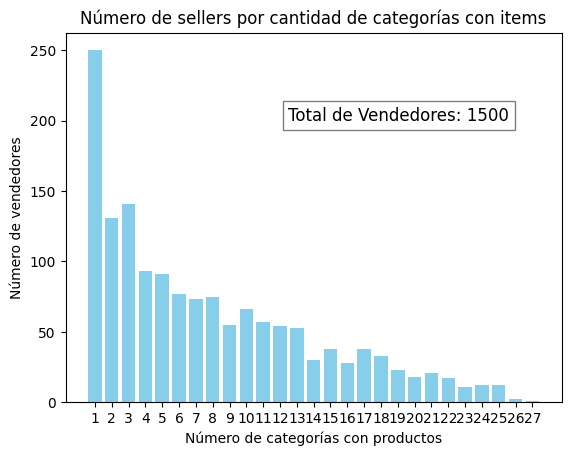

In [30]:
# visualización por gráfico de barras
plt.bar(df_conteo.index, df_conteo.values, color='skyblue')
plt.xlabel('Número de categorías con productos')
plt.ylabel('Número de vendedores')
plt.title('Número de sellers por cantidad de categorías con items')
plt.xticks(df_conteo.index)  # Asegurarse de que los ticks correspondan
plt.text(12.5, max(df_conteo.values) * 0.8, f'Total de Vendedores: {len(conteo)}', 
         fontsize=12, ha='left', bbox=dict(facecolor='white', alpha=0.5))
plt.show()


### Visualización de datamart de sellers con PCA

In [31]:
# eliminar la variable id_seller para el análisis
datamart_pca_data = datamart.drop(columns=['id_seller'])

# estandarización de los datos
scaler = StandardScaler()
datamart_scaled = scaler.fit_transform(datamart_pca_data)

# entrenamiento de PCA
pca = PCA(n_components = min(datamart_scaled.shape))  # pca generando todas las componentes
pca_fit = pca.fit_transform(datamart_scaled) # entrenamiento y transformación de los datos

# dataframe con las componentes
pca_df = pd.DataFrame(data=pca_fit, columns=[f'PC{i+1}' for i in range(pca_fit.shape[1])])

# agregamos el id del seller
pca_df["id_seller"] = datamart.id_seller


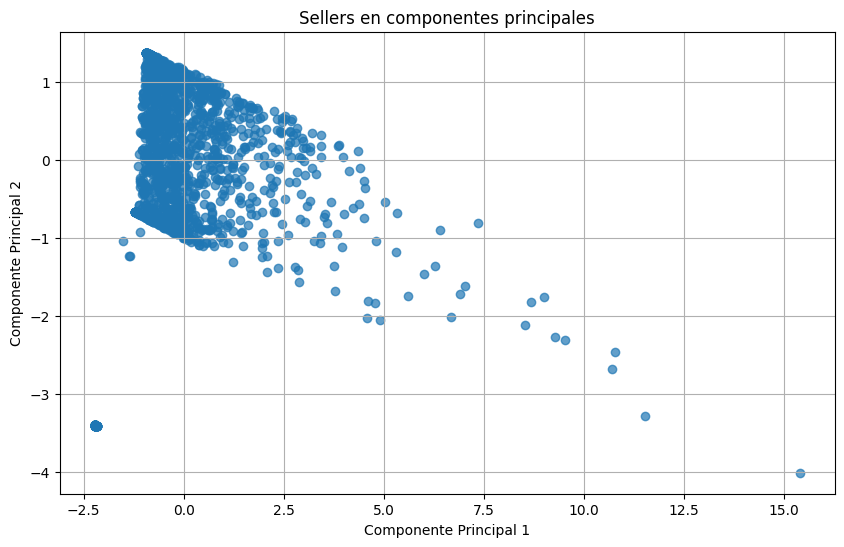

In [32]:
# visualización de las primeras 2 componentes
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)

plt.title('Sellers en componentes principales')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.grid()
plt.show()

## 3. Detección de outliers (por arriba) y clasificación de sellers

### Detección de outliers en 2 componentes principales
Para detectar a los sellers con un comportamiento extraordinario, se detectan los outliers de las primeras 2 componentes

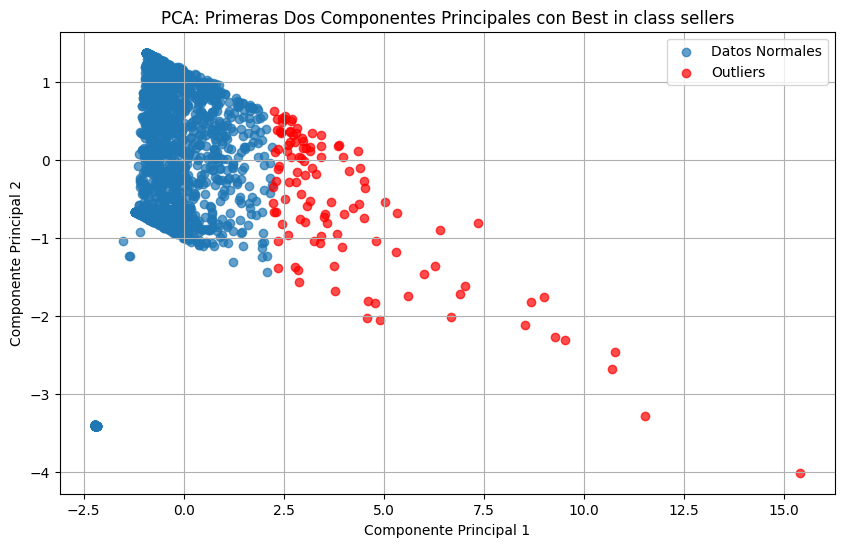

In [33]:
# cuartiles para la componente 1
Q1_PC1 = np.percentile(pca_df['PC1'], 25)
Q3_PC1 = np.percentile(pca_df['PC1'], 75)

# rango intercuartílico para la componente 1
IQR_PC1 = Q3_PC1 - Q1_PC1

# límite superior por regla de rango intercuartílico para la componente 1
upper_bound_PC1 = Q3_PC1 + 1.5 * IQR_PC1

# cuartiles para la componente 2
Q1_PC2 = np.percentile(pca_df['PC2'], 25)
Q3_PC2 = np.percentile(pca_df['PC2'], 75)

# rango intercuartílico para la componente 2
IQR_PC2 = Q3_PC2 - Q1_PC2

# límite superior por regla de rango intercuartílico para la componente 2
upper_bound_PC2 = Q3_PC2 + 1.5 * IQR_PC2

# selección de outliers
outliers = (pca_df['PC1'] > upper_bound_PC1) | (pca_df['PC2'] > upper_bound_PC2)

# visualización en componentes principales
plt.figure(figsize=(10, 6))
plt.scatter(pca_df[~outliers]['PC1'], pca_df[~outliers]['PC2'], alpha=0.7, label='Datos Normales')

# graficar outliers
plt.scatter(pca_df[outliers]['PC1'], pca_df[outliers]['PC2'], 
            color='red', alpha=0.7, label='Outliers')

# leyenda para distinción de datos
plt.legend()
plt.title('PCA: Primeras Dos Componentes Principales con Best in class sellers')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.grid()
plt.show()

### Clasificación de sellers generando un grid con la mediana de las componentes

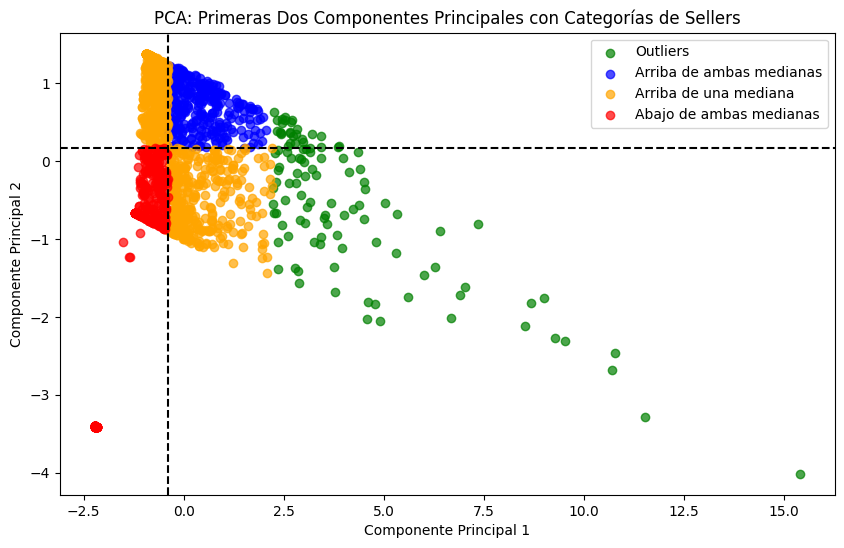

In [34]:
# medianas de las componentes principales
median_PC1 = np.median(pca_df['PC1'])
median_PC2 = np.median(pca_df['PC2'])

# dataframe para clasificar los puntos de acuerdo a su posición con respecto a la mediana
conditions = np.zeros(pca_df.shape[0])  

# asignar colores según las condiciones
for i in range(pca_df.shape[0]):
    if outliers[i]:
        conditions[i] = 1  # Outliers
    elif pca_df['PC1'][i] > median_PC1 and pca_df['PC2'][i] > median_PC2:
        conditions[i] = 2  # Arriba de ambas medianas
    elif pca_df['PC1'][i] > median_PC1 or pca_df['PC2'][i] > median_PC2:
        conditions[i] = 3  # Arriba de una mediana
    else:
        conditions[i] = 4  # Abajo de ambas medianas

# visualización de la clasificación
plt.figure(figsize=(10, 6))

# graficar outliers
plt.scatter(pca_df[conditions == 1]['PC1'], pca_df[conditions == 1]['PC2'], 
            color='green', alpha=0.7, label='Outliers')

# graficar puntos arriba de ambas medianas
plt.scatter(pca_df[conditions == 2]['PC1'], pca_df[conditions == 2]['PC2'], 
            color='blue', alpha=0.7, label='Arriba de ambas medianas')

# graficar puntos arriba de una mediana
plt.scatter(pca_df[conditions == 3]['PC1'], pca_df[conditions == 3]['PC2'], 
            color='orange', alpha=0.7, label='Arriba de una mediana')

# graficar puntos abajo de ambas medianas
plt.scatter(pca_df[conditions == 4]['PC1'], pca_df[conditions == 4]['PC2'], 
            color='red', alpha=0.7, label='Abajo de ambas medianas')

# líneas de mediana
plt.axvline(x=median_PC1, color='black', linestyle='--')
plt.axhline(y=median_PC2, color='black', linestyle='--')

plt.legend()
plt.title('PCA: Primeras Dos Componentes Principales con Categorías de Sellers')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.show()

## 4. Características de la clasificación
Una vez generada la clasificación, se observan las distinciones entre las variables

In [35]:
# para renombrar la clasificación
classification_map = {
    1: 'best sellers',   # Outliers
    2: 'good sellers',    # Arriba de ambas medianas
    3: 'average sellers', # Arriba de una mediana
    4: 'worst sellers'    # Abajo de ambas medianas
}

# asignar las condiciones a una nueva columna en el datamart
datamart['classification'] = np.where(outliers, 1,  # Outliers
                                       np.where((pca_df['PC1'] > median_PC1) & (pca_df['PC2'] > median_PC2), 2, # Arriba de ambas medianas
                                       np.where((pca_df['PC1'] > median_PC1) | (pca_df['PC2'] > median_PC2), 3, 4)))  # Arriba de una mediana o abajo de ambas

# renombrar la clasificación
datamart['classification'] = datamart['classification'].map(classification_map)

# unir la clasificación con el dataset original
df_items = df_items.merge(datamart[['id_seller', 'classification']])

# número de items y categorías únicas por seller y su respectiva clasificación
unique_products_per_seller = df_items.groupby(['id_seller', 'classification'])[['id_item', 'categoria']].nunique().reset_index()


# resumen de variables por clasificación
summary = unique_products_per_seller.groupby('classification').agg(
    count = ('id_seller', 'nunique'),  # conteo de vendedores únicos
    n_categories = ('categoria', 'median'),  # calcular la mediana de categorías distintas
    n_products = ('id_item', 'median')  # calcular la mediana de productos únicos por clasificación
).reset_index()

print(summary)

    classification  count  n_categories  n_products
0  average sellers    729           5.0        74.0
1     best sellers    111          18.0      1039.0
2     good sellers    316           9.0       284.0
3    worst sellers    344           3.0        27.0


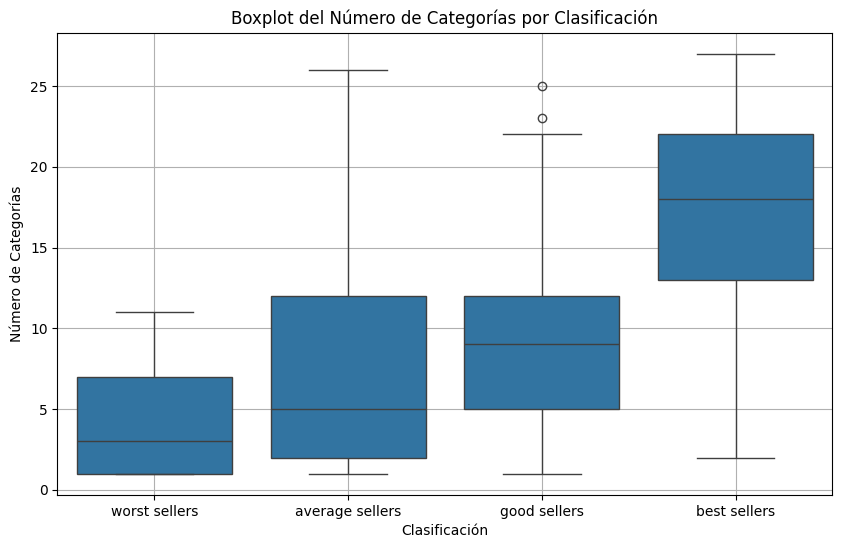

In [36]:
# boxplot de número de categorías distintas por clasificación
plt.figure(figsize=(10, 6))
sns.boxplot(data=unique_products_per_seller, x='classification', y='categoria', order = ['worst sellers', 'average sellers','good sellers', 'best sellers'])

plt.title('Boxplot del Número de Categorías por Clasificación')
plt.xlabel('Clasificación')
plt.ylabel('Número de Categorías')

plt.grid()
plt.show()

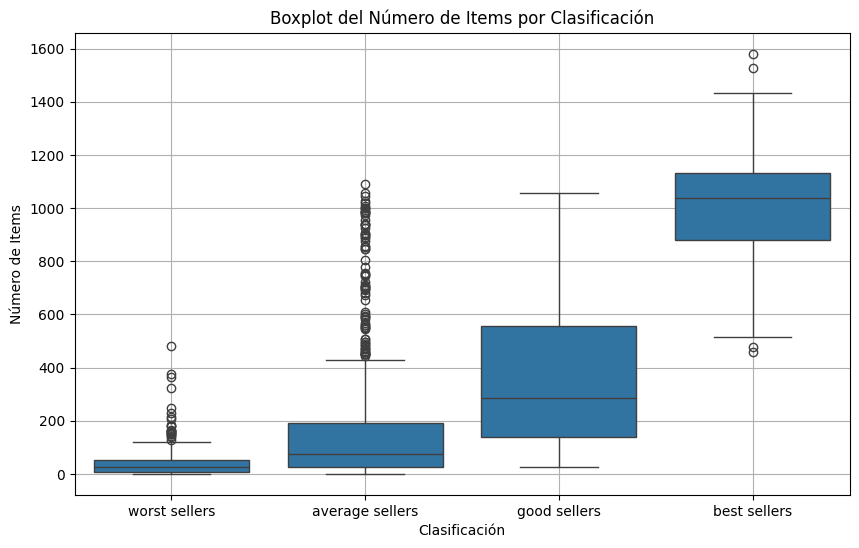

In [37]:
# boxplot de número de items por clasificación
plt.figure(figsize=(10, 6))
sns.boxplot(data=unique_products_per_seller, x='classification', y='id_item', order = ['worst sellers', 'average sellers','good sellers', 'best sellers'])

plt.title('Boxplot del Número de Items por Clasificación')
plt.xlabel('Clasificación')
plt.ylabel('Número de Items')

plt.grid()
plt.show()